## Burger's Equation

\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The DeepONet method (Cartesian)

### (2.1) Prepare data

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of a_train: torch.Size([1000, 128])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridx_train: torch.Size([128, 1])
The shape of a_test: torch.Size([50, 128])
The shape of uT_train: torch.Size([50, 128, 1])
The shape of gridx_test: torch.Size([128, 1])


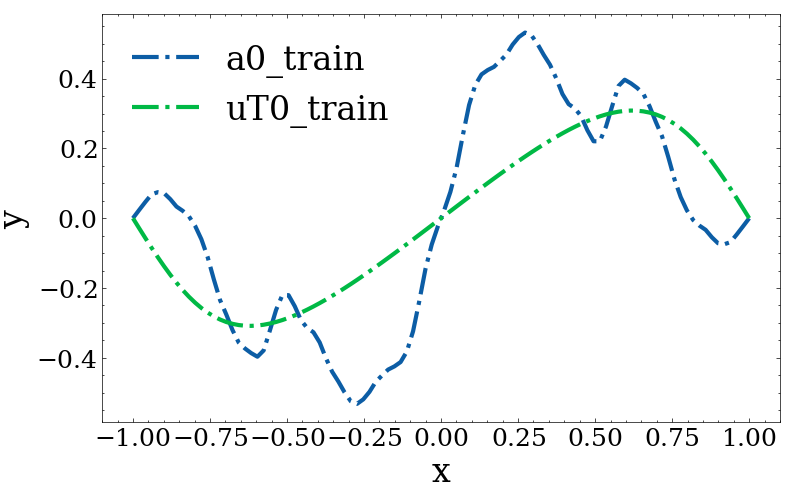

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
# Load training data
######################################
from Utils.utils import *
n_train, n_test = 1000, 50
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np2tensor(np.array(data['x_mesh']))
    #
    a = a.reshape(ndata, -1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, uT, x_mesh
#
a_train, uT_train, gridx_train = get_data(data_train, n_train, dtype)
a_test, uT_test, gridx_test = get_data(data_test, n_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
#
print('The shape of a_test:', a_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
inx = 5
#
Plot.show_1d_list(gridx_train, [a_train[inx], uT_train[inx]], ['a0_train', 'uT0_train'], lb =-1.)

### (2.2) Define the loss class

In [2]:
###############################
# Set normalizer
###############################
from sklearn.preprocessing import StandardScaler

class Normalizer_a(object):

    def __init__(self, scale:float=0.1, shift:float=0.75):
        self.scale = scale
        self.shift = shift
        
    def encode(self, a:torch.tensor):
        '''
        Input: 
            a: (n_batch, n_mesh) 
        '''
        return a * self.scale - self.shift
        
    def decode(self, a:torch.tensor):
        '''
        Input: 
            a: (n_batch, n_mesh)
        '''
        return (a+self.shift)*self.scale
#
normalizer_a = Normalizer_a(1., 0.)

###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, a_norm)
        #
        loss = self.solver.getLoss(u_pred, u)
        
        return loss

    def Error(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, a_norm)
        #
        err = self.solver.getError(u_pred, u)
        
        return err

######################################
# Steups of the model
######################################
from Solvers.DeepONet import DeepONet
solver = DeepONet.Solver(device, dtype)
netType = 'DeepONetCartesian'
#
layers_branch, activation_branch = [128, 128, 128, 128, 128], 'Tanh'
layers_trunk, activation_trunk = [1, 128, 128, 128, 128], 'Tanh'
model_u = solver.getModel(layers_branch, layers_trunk, activation_branch, activation_trunk, 
                        multi_ouput_strategy=None, num_output=1, netType='Cartesian')
# # ###############################
from torchsummary import summary
summary(model_u, [(1,), (128,)], device='cpu')
# ###############################
total_params = sum(p.numel() for p in model_u.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          16,512
              Tanh-2                  [-1, 128]               0
              Tanh-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              Tanh-5                  [-1, 128]               0
              Tanh-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              Tanh-8                  [-1, 128]               0
              Tanh-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
            FCNet-11                  [-1, 128]               0
           Linear-12                  [-1, 128]             256
             Tanh-13                  [-1, 128]               0
             Tanh-14                  [

### (2.3) Training and making prediction

#### (2.3.1) Training 

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', step_size=500)
solver.train_cartesian(LossClass, a_train, uT_train, gridx_train, a_test, uT_test, gridx_test, 
                       batch_size=50, epochs=2000, epoch_show=100, **{'save_path':f'saved_models/{netType}/'})

  5%|███▌                                                                 | 104/2000 [00:05<01:16, 24.91it/s]

Epoch:100 Time:5.1936, loss_train:0.215069, loss_test:0.259242
          lr: 0.001 err_test 0.15513072907924652


 10%|███████                                                              | 203/2000 [00:09<01:11, 25.07it/s]

Epoch:200 Time:9.1927, loss_train:0.139232, loss_test:0.146570
          lr: 0.001 err_test 0.08992840349674225


 15%|██████████▌                                                          | 305/2000 [00:13<01:06, 25.35it/s]

Epoch:300 Time:13.1855, loss_train:0.149631, loss_test:0.141058
          lr: 0.001 err_test 0.08138065040111542


 20%|█████████████▉                                                       | 404/2000 [00:17<01:03, 25.22it/s]

Epoch:400 Time:17.1496, loss_train:0.117244, loss_test:0.113477
          lr: 0.001 err_test 0.07296357303857803


 25%|█████████████████▎                                                   | 503/2000 [00:21<00:59, 24.98it/s]

Epoch:500 Time:21.1248, loss_train:0.071873, loss_test:0.095613
          lr: 0.0005 err_test 0.059716977179050446


 30%|████████████████████▊                                                | 605/2000 [00:25<00:55, 25.07it/s]

Epoch:600 Time:25.1334, loss_train:0.066687, loss_test:0.073266
          lr: 0.0005 err_test 0.04275402054190636


 35%|████████████████████████▎                                            | 704/2000 [00:29<00:51, 25.10it/s]

Epoch:700 Time:29.0953, loss_train:0.058412, loss_test:0.046525
          lr: 0.0005 err_test 0.030665099620819092


 40%|███████████████████████████▋                                         | 803/2000 [00:33<00:47, 25.29it/s]

Epoch:800 Time:33.0771, loss_train:0.043528, loss_test:0.043478
          lr: 0.0005 err_test 0.029985548928380013


 45%|███████████████████████████████▏                                     | 905/2000 [00:37<00:43, 25.34it/s]

Epoch:900 Time:37.0465, loss_train:0.045141, loss_test:0.039156
          lr: 0.0005 err_test 0.027085212990641594


 50%|██████████████████████████████████▏                                 | 1004/2000 [00:41<00:40, 24.70it/s]

Epoch:1000 Time:41.0413, loss_train:0.049247, loss_test:0.050884
          lr: 0.00025 err_test 0.033141665160655975


 55%|█████████████████████████████████████▌                              | 1103/2000 [00:45<00:35, 25.07it/s]

Epoch:1100 Time:45.0666, loss_train:0.035391, loss_test:0.036219
          lr: 0.00025 err_test 0.022418061271309853


 60%|████████████████████████████████████████▉                           | 1205/2000 [00:49<00:31, 25.15it/s]

Epoch:1200 Time:49.0578, loss_train:0.027757, loss_test:0.028296
          lr: 0.00025 err_test 0.018492119386792183


 65%|████████████████████████████████████████████▎                       | 1304/2000 [00:53<00:27, 25.17it/s]

Epoch:1300 Time:53.0415, loss_train:0.032719, loss_test:0.043281
          lr: 0.00025 err_test 0.02629803866147995


 70%|███████████████████████████████████████████████▋                    | 1403/2000 [00:57<00:23, 24.95it/s]

Epoch:1400 Time:57.0308, loss_train:0.024292, loss_test:0.024152
          lr: 0.00025 err_test 0.01672588475048542


 75%|███████████████████████████████████████████████████                 | 1502/2000 [01:01<00:19, 24.92it/s]

Epoch:1500 Time:61.0130, loss_train:0.024877, loss_test:0.023892
          lr: 0.000125 err_test 0.016283391043543816


 80%|██████████████████████████████████████████████████████▌             | 1604/2000 [01:05<00:15, 25.13it/s]

Epoch:1600 Time:65.0160, loss_train:0.021385, loss_test:0.022216
          lr: 0.000125 err_test 0.014626266434788704


 85%|█████████████████████████████████████████████████████████▉          | 1703/2000 [01:09<00:11, 25.01it/s]

Epoch:1700 Time:69.0052, loss_train:0.020553, loss_test:0.021221
          lr: 0.000125 err_test 0.014929601922631264


 90%|█████████████████████████████████████████████████████████████▎      | 1805/2000 [01:13<00:07, 25.19it/s]

Epoch:1800 Time:73.0047, loss_train:0.022221, loss_test:0.024494
          lr: 0.000125 err_test 0.016111845150589943


 95%|████████████████████████████████████████████████████████████████▋   | 1904/2000 [01:17<00:04, 23.82it/s]

Epoch:1900 Time:77.0409, loss_train:0.022322, loss_test:0.021495
          lr: 0.000125 err_test 0.014045474119484425


100%|████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.70it/s]

Epoch:2000 Time:80.9859, loss_train:0.021775, loss_test:0.020507
          lr: 6.25e-05 err_test 0.014533009380102158
The total training time is 80.9909


### (3) load saved model and make prediction

The shape of a_test: torch.Size([50, 128])
The shape of uT_test: torch.Size([50, 128, 1])
The test loss tensor(0.0205)
The test l2 error: tensor(0.0145)
*************************************
The test l2 error for 0: tensor(0.0274)
The test l2 error for 1: tensor(0.0077)
The test l2 error for 2: tensor(0.0070)
The test l2 error for 3: tensor(0.0105)
The test l2 error for 4: tensor(0.0191)


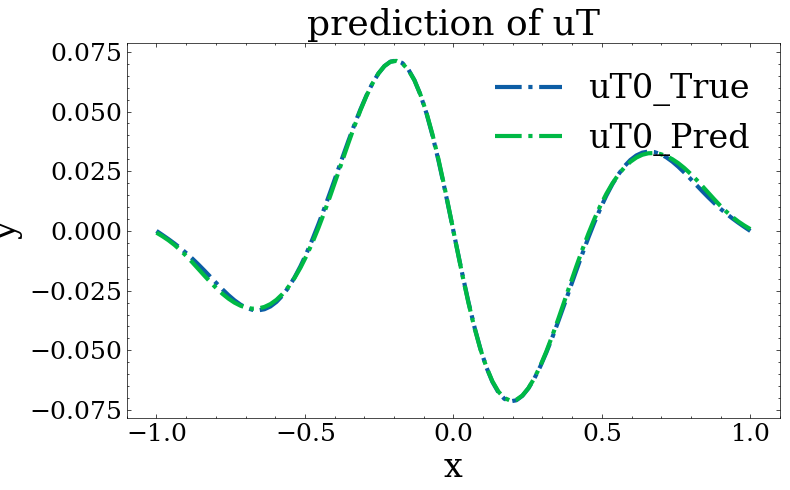

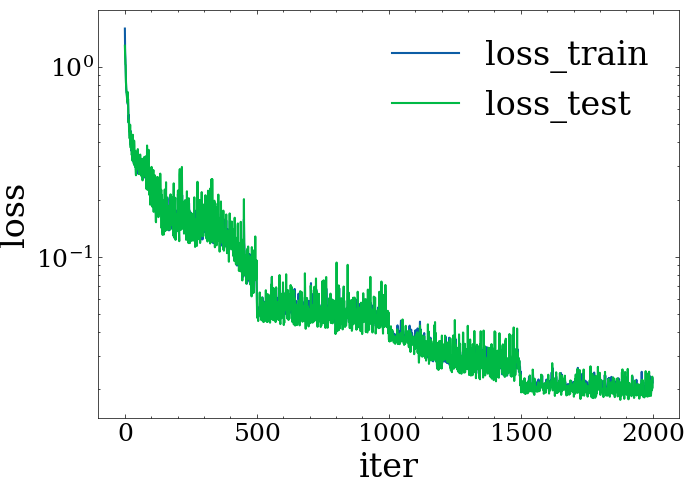

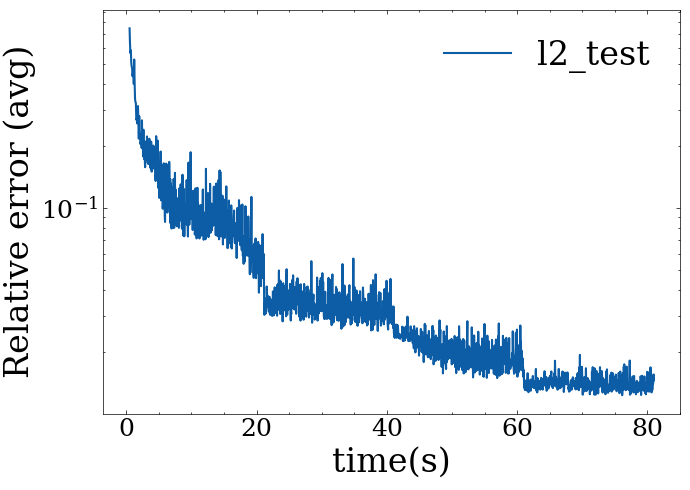

In [3]:
#####################################
# Load the trained model
#####################################
from Solvers.DeepONet import DeepONet
solver = DeepONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_deeponet_final')

#########################################
with torch.no_grad():
    a = normalizer_a.encode(a_test.to(device))
    uT_pred = model_trained['u'](gridx_test.to(device), a)
    uT_pred = uT_pred.detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of uT_test:', uT_test.shape)
print('The test loss', solver.getLoss(uT_pred, uT_test))
print('The test l2 error:', solver.getError(uT_pred, uT_test))
print('*************************************')
for i in range(0, 5):
    print(f'The test l2 error for {i}:', solver.getError(uT_pred[i:i+1], uT_test[i:i+1]))
inx = 0
# ########################################
from Utils.PlotFigure import Plot
# show prediction
Plot.show_1d_list(gridx_test, [uT_test[inx], uT_pred[inx]], 
                  label_list=['uT0_True', 'uT0_Pred'], title='prediction of uT')
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_deeponet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test']], ['l2_test'])